In [1]:
library(dplyr) #Loading all libraries 
library(tidyr)
library(purrr)
library(forcats)
library(readr)
library(readxl)
library(ggplot2)
library(cowplot)
library(repr)
library(RPostgres)
library(RSQLite)
library(workflows)
library(recipes)
library(parsnip)
library(DBI)
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(janitor)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ stringr   1.5.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ stringr::fixed()   masks recipes::fixed()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials

In [2]:
download.file("https://raw.githubusercontent.com/An-Dao/dsci_project/main/data/healthcare_dataset%202.csv","data/healthcare_data_read.csv")
health_data <- read_csv("data/healthcare_data_read.csv")

# Define age ranges
age_ranges <- c(0, 20, 30, 40, 50, 60, 70, 80, Inf)
age_labels <- c("0-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81+")

compress_health_data <- health_data |> 
    clean_names() |>
    select(-c(date_of_admission:discharge_date,name,medication,test_results))|>
    mutate(age_range = cut(age, breaks = age_ranges, labels = age_labels, include.lowest = TRUE))

compress_health_data |> head(10)
write.csv(compress_health_data, "data/medical_condition_data.csv")

Rows: 10000 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Name, Gender, Blood Type, Medical Condition, Doctor, Hospital, In...
dbl   (3): Age, Billing Amount, Room Number
date  (2): Date of Admission, Discharge Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,gender,blood_type,medical_condition,age_range
<dbl>,<chr>,<chr>,<chr>,<fct>
81,Female,O-,Diabetes,81+
35,Male,O+,Asthma,31-40
61,Male,B-,Obesity,61-70
49,Male,B-,Asthma,41-50
51,Male,O-,Arthritis,51-60
41,Male,AB+,Arthritis,41-50
82,Male,AB+,Hypertension,81+
55,Female,O-,Arthritis,51-60
33,Male,A+,Diabetes,31-40


In [3]:
set.seed(2000) 


health_split <- initial_split(compress_health_data, prop = 3/4, strata = medical_condition)
health_training <- training(health_split)
health_testing <- testing(health_split)

In [4]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis). 
#An example of a useful table could be one that reports the number of observations in each class, 
#the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

count_blood_type <- health_training |>
    group_by(blood_type)|>
    summarize(count = n())
count_blood_type 

count_gender <- health_training |>
    group_by(gender)|>
    summarize(count = n())
count_gender


count_age_range <- health_training |>
    group_by(age_range)|>
    summarize(count = n())
count_age_range

count_med_cond <- health_training |>
    group_by(medical_condition) |>
    summarize(count = n())
count_med_cond

summary_data <- health_training |>
    group_by (age_range,blood_type, gender, medical_condition)|>
    summarize(count = n() )
summary_data

blood_type,count
<chr>,<int>
A+,958
A-,934
AB+,946
AB-,943
B+,901
B-,948
O+,914
O-,955


gender,count
<chr>,<int>
Female,3785
Male,3714


age_range,count
<fct>,<int>
0-20,343
21-30,1077
31-40,1117
41-50,1013
51-60,1142
61-70,1106
71-80,1171
81+,530


medical_condition,count
<chr>,<int>
Arthritis,1237
Asthma,1281
Cancer,1277
Diabetes,1217
Hypertension,1266
Obesity,1221


`summarise()` has grouped output by 'age_range', 'blood_type', 'gender'. You
can override using the `.groups` argument.


age_range,blood_type,gender,medical_condition,count
<fct>,<chr>,<chr>,<chr>,<int>
0-20,A+,Female,Arthritis,10
0-20,A+,Female,Asthma,4
0-20,A+,Female,Cancer,4
0-20,A+,Female,Diabetes,2
0-20,A+,Female,Hypertension,3
0-20,A+,Female,Obesity,1
0-20,A+,Male,Arthritis,5
0-20,A+,Male,Asthma,5
0-20,A+,Male,Cancer,3


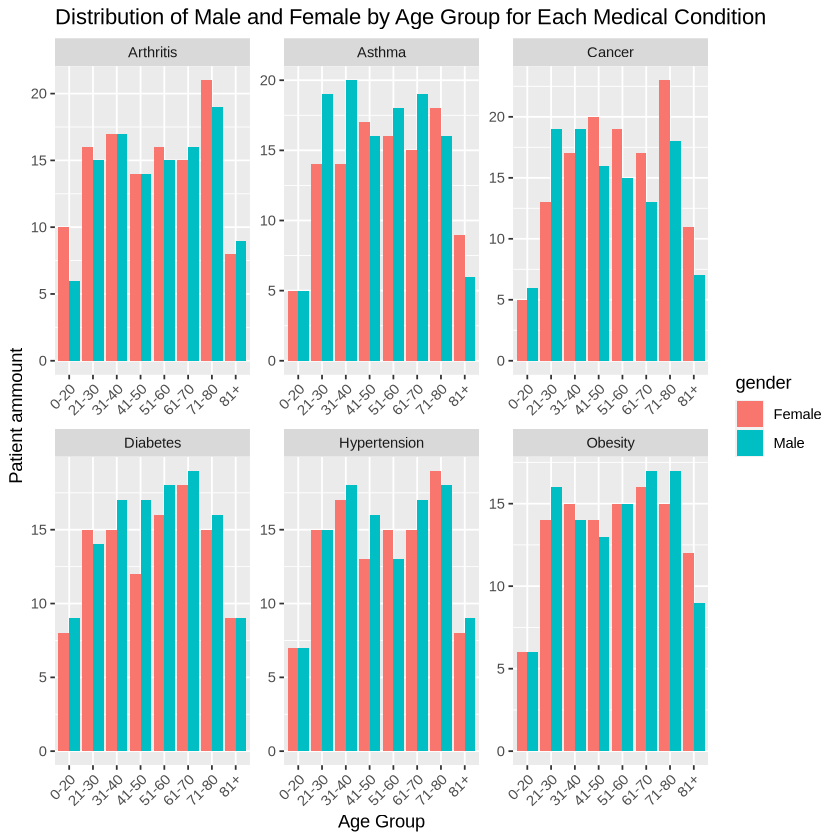

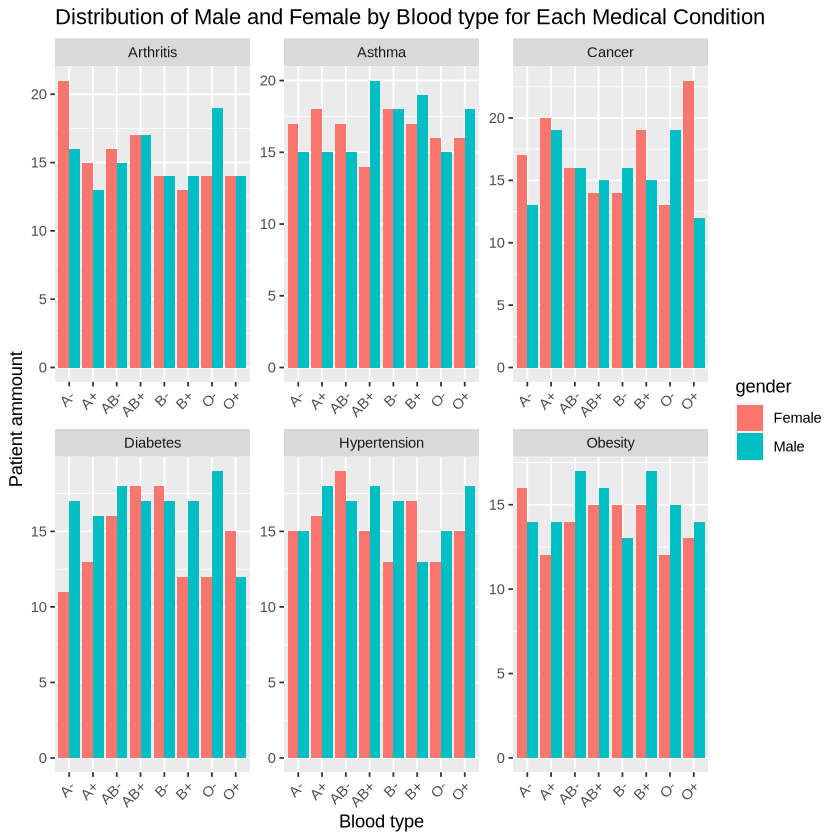

In [5]:

training_plot <- summary_data |>
   ggplot(aes(x = age_range, y = count, fill = gender)) + 
    geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ medical_condition, scales = "free") +
  labs(title = "Distribution of Male and Female by Age Group for Each Medical Condition", x = "Age Group", y = "Patient ammount")+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

training_plot2 <- summary_data |>
   ggplot(aes(x = blood_type, y = count, fill = gender)) + 
    geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ medical_condition, scales = "free") +
  labs(title = "Distribution of Male and Female by Blood type for Each Medical Condition", x = "Blood type", y = "Patient ammount")+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
training_plot
training_plot2

**Preliminary exploratory data analysis:**
<br> 
Our data are source from https://www.kaggle.com/datasets/prasad22/healthcare-dataset/data, we weren't able to read from the website. However we read it by downloading the file and import into our repository then we get the directory of the raw file on github. 

The data is read into health_data, although the table is tidy, there were too many variable that are unessary for our our project, we've shortend the table with age, gender, blood_type, medical_condition and age_group of which will split the age into 8 groups of 0-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81+. Although every other age group are split by 10 years gap we decided to group 0-10 and 11-20 together as they have severely lack of data.

To split the data into training and testing set we have picked a random seed of2000 and split by 3/4 with 3 part go to training set and remaining for testing. We've group and find each variable's ammount and conclude that data are fairly evenly distributed for all the group we did, the main table is the summary_data which count the number of patient that has medical condition by age_group, blood_type and gender.

We then visualize the summary_data into bar graph showing the distribution of male and female having medical condition. We are able to verify the even distribution between male and female patient in all age_group for each of medical condition. This even spread will allow our model to have a higher precision.

**Contributor:**
<br>*An Dao*